In [15]:
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


## Analyse des réponses du sondage des tuteurs de l'UVCI
Ce cachier présenter le code permettant d'analyser une feuille générée par google sheet lors d'un sondage en ligne
- Chaque ligne du fichiers *xlsx* est une réponse
- Chaque colonnes est une questions.  Il y a plusieurs types de questions.  Certaines avec des réponses numériques, d'autres avec des strings.  Les réponses numériques sont en générale des classes de 1 à 5 représentant un niveau d'accord ou de désacord avec une affirmation qui tien lieu de question.

### charger le fichier avec les résultas

In [16]:
fname = 'sondage_tuteursUVCI_reponses.xlsx'
df =  pd.read_excel(fname)

#### Nettoyer

In [17]:
def naCols(df):
    """renvoie les colonnes qui sont pleine de valeurs inconnues (nan)"""
    L =  []
    for c in df.columns:
        if all(df.loc[:,c].isna()):
            L.append(c)
    return L

In [ ]:
##### Enlever les colonnes pleines de nan

In [18]:
df = df.drop(labels=naCols(df), axis=1)

In [ ]:
##### Enlever les lignes (réponses) qui ne sont pas des réponses originale mais mes essais

In [19]:
df = df.drop(df.loc[df.iloc[:,1] == 1].index)

#### Renvoyer à la ligne les longs label des colonnes
- les '\n' sont ajoutés manuellement

In [20]:
df.columns = (
    ["Horodateur", "On apprend mieux\nà plusieurs que seul",
     "Les NTIC permettent\nune meilleure collaboration entre les individus",
     "Les NTIC renforcent\nle sentiment d'isolement des individus",
     "Je sais facilement\nqui est connecté",
     "Je sais facilement\nqui répond à qui",
     "Lorsque je cherche un message,\nje le retrouve facilement",
     "Je suis satisfait\ndes outils de suivi existant\nou de ma façon de suivre\nle travail des apprenants en ligne",
     "Combien de temps en moyenne\npar semaine passez-vous actif,\nsur les tchats de vos groupes ?",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[hors-ligne]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Google hangout]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[sur les forums de l'UVCI]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Facebook, ]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Whatsapp,]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[par Mail]",
     "Quels autres moyens de communication\nvos étudiants utilisent-ils\npour travailler ensemble ?",
     "Que pouvez-vous ajouter\nsur les  habitudes de travail\nde vos étudiants ?",
     "Voir le nombre total\nde messages publiés\nc'est",
     "Voir le nombre total\nde messages publiés pour chaque étudiants\nc'est",
     "Voir les messages publiés\npour une période donnée\nc'est",
     "Accéder facilement au contenu\ndes messages publiés à n'importe quel moment\nc'est",
     "Voir facilement si\nun message est une question\nc'est",
     "Voir facilement si\nun message est une réponse\nc'est",
     "Voir facilement si\nun message est hors-sujet\nc'est",
     "Voir le nombre d'étudiants connectés\ndepuis le début de la session\nc'est",
     "Voir le nombre d'étudiants connectés\nà un moment donné\nc'est",
     "Voir des statistiques sur\nles contenus des messages\nc'est",
     "Voir des statistiques sur\nles messages\nc'est",
     "Voir des statistiques sur\nles auteurs des messages c'est",
     "Finalement quoi d'autre,\nserait-il important de visualiser\npour améliorer le suivi de vos apprenants ?",
     "Quels sont les niveaux (semestres)\net spécialités de vos groupes d'étudiants?"])

#### Déterminer le type des Questions (colonnes)
On utilise le type des données dans les colonnes pour en déduire le type de réponses attendues.  Les réponses peuvent être
- Ouvertes: n'importe quelle chaine de caractères
- à choix multiple: une chaine de caractères parmi un choix limité
- mesurées sur une échelle:  La réponse est un nombre entre 0 et 5 indiquant souvant un degré d'accord ou de désacord.
- continue : mais il n'y en a pas dans ce jeu de données.
- vraie ou faux: un nombre 0 ou 1, équivalent à False ou True

In [21]:
estCols = []  # questions en est utile/inutile (type échelle)
okCols = [] # questions d'accords (échelle de confidence)
tCols = [] # questions vrai ou faux (chaine de caractères limitée)
oCols = []  # questions ouvertes 

# les colonnes avec des réponses numériques (échelle)
for c in df.columns:
    if (df.loc[:, c].dtype in [int or float]
        and df.loc[:, c].max() <= 5
        and df.loc[:, c].min() >= 0):
        if "c'est" in c:
            estCols.append(c)
        else:
            okCols.append(c)

# les responses en string  
strCols = set(df.columns) - set(estCols) - set(okCols)
for c in strCols:
    if 'Pour travailler' in c:
        tCols.append(c)
    else:
        oCols.append(c)

## Représenter

Les données sont facilement réprésentées en utilisant les fonctions internes de *pandas* ou simplent en utilisant les outils googles. Mais je souhaite m'entrainer à faire des graphs en python.

### Avec les outils par défaut de pandas

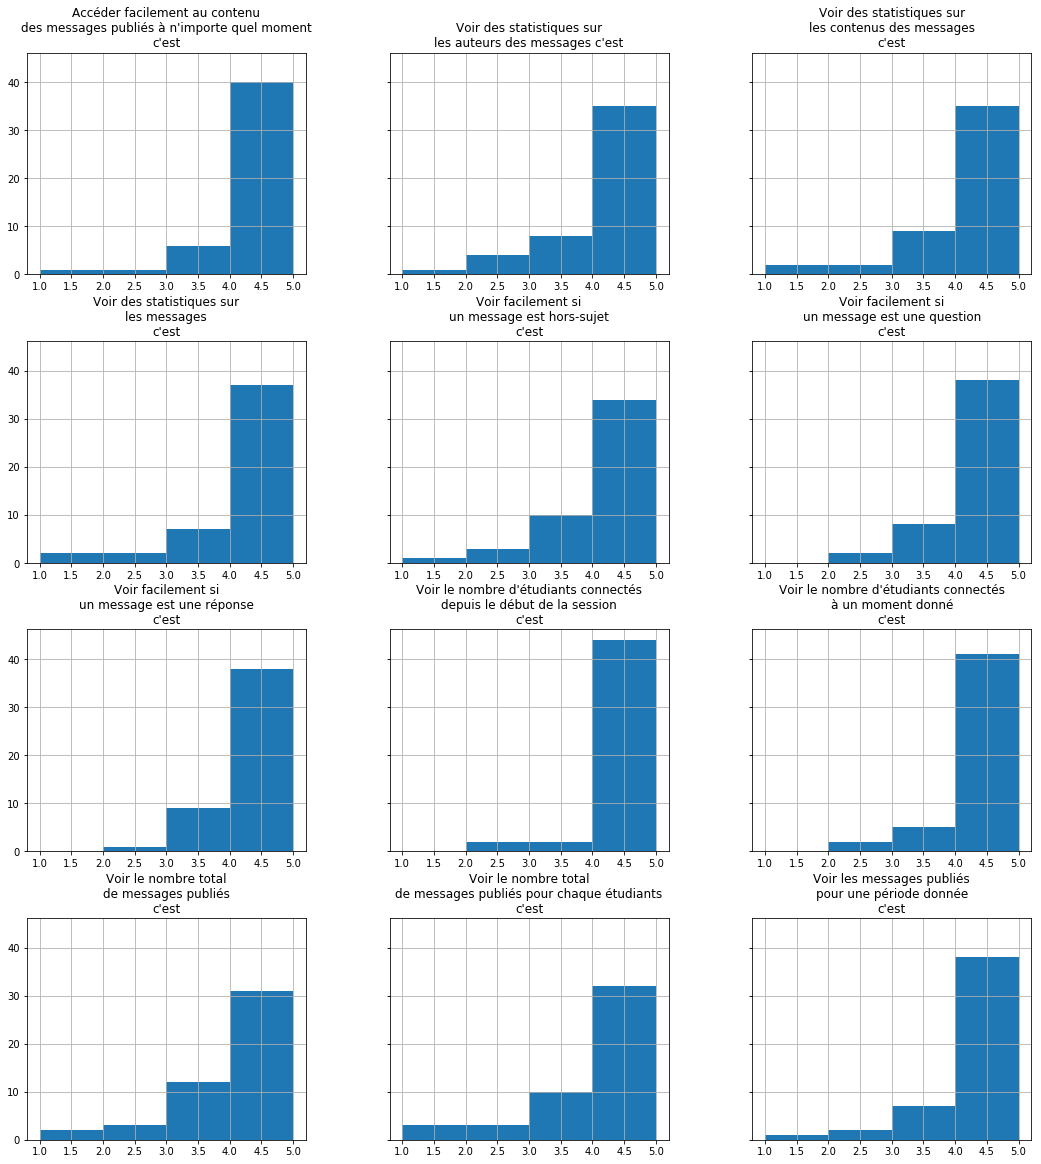

In [54]:
_ = df.loc[:,estCols].hist(figsize=(18,20),bins=range(1,6),grid=True, sharey=True)

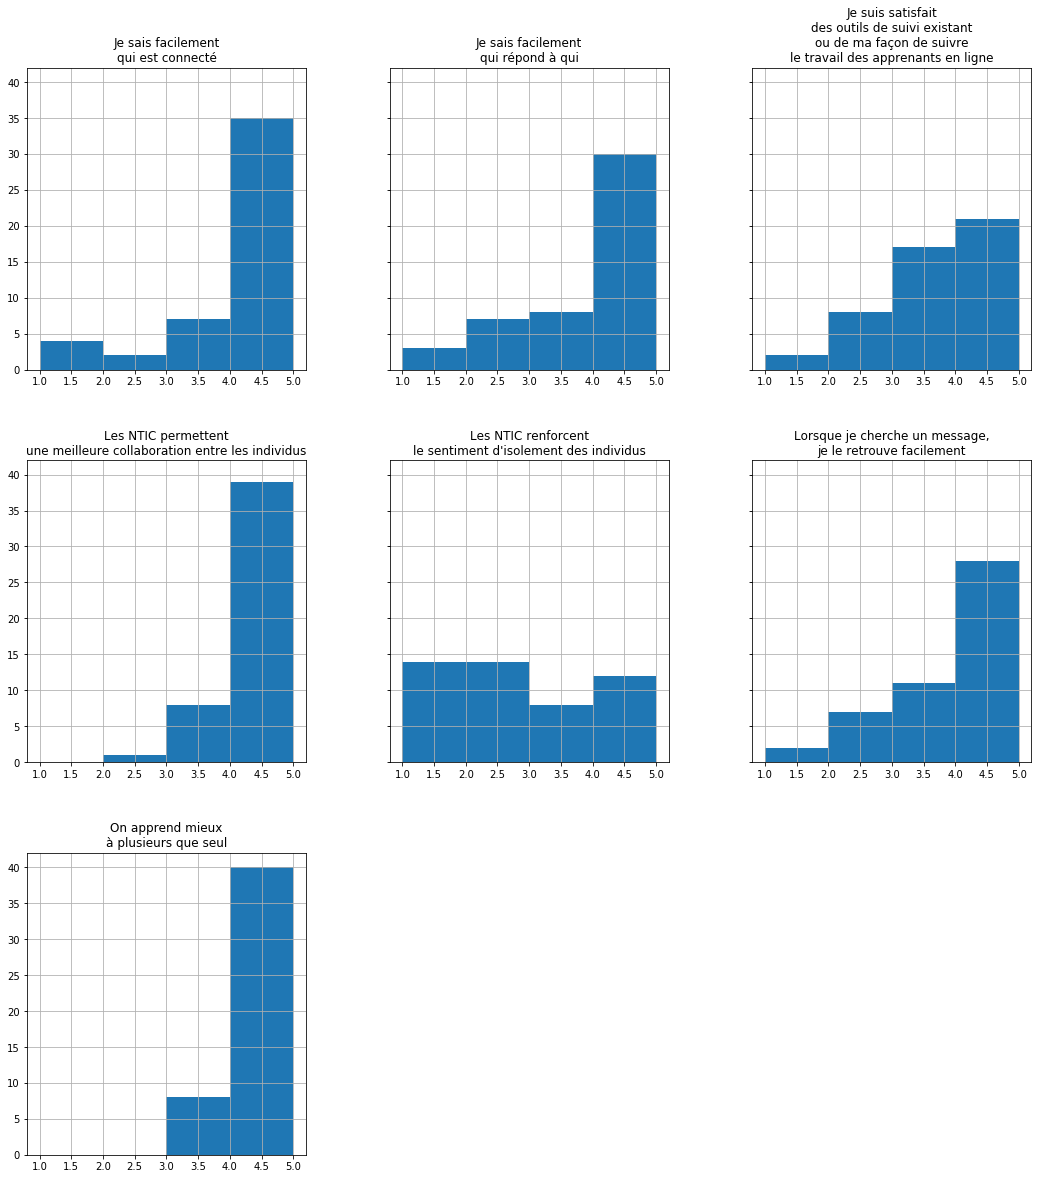

In [44]:
_ = df.loc[:,okCols].hist(figsize=(18,20),bins=range(1,6),grid=True, sharey=True)

### On dessine les résultats plus manuellemnt

In [62]:
# Définir des fonctions de pré-traitement des données
def get_hist_df(df):
    """Soit un df, renvois le compte des valeurs de chaques colonnes dans un tableau (dataframe)
    Les colonnes dud df sont des questions\n
    Les lignes de df sont les réponses.\n
    En sortie on a un hist_df avec les catagorie de réponses en index et les questions en colonnes et les cumuls en valeurs"""

    # un dic pour chaque colonne on a une pd.Serie de value_counts() (ie. values and counts)
    D = {}
    for c in df:
        D[c] = df.loc[:,c].value_counts()
        
    hist_df = pd.DataFrame(D)
    return hist_df

In [63]:

def plot_stacked_horizontal_bar_chart(df, labels, title, reverse=False, size=(13,8), strfmt="%3d%%", **args):
    """Fonction pour dessier un graphique en bar cumulé et horizontale
    le df doit être issue de la fonction get_hist_df.  
    reverse=False, size=(13,8), strfmt=\"%3d%%\""""
    fig, ax = plt.subplots()
    if reverse:
        df = df[::-1]
        labels = labels[::-1]

    for j in range(len(df)): 
        # pour catégorie on décale vers la droite pour faire un stackbarh
        if j > 0:
            arg = {'left': df.iloc[:j,:].sum()}
        else:
            arg = {'left': [0]*len(df.columns)}
            # on plot la catégorie sur le graphique
        plt.barh(df.columns, df.iloc[j].values, label=labels[j], **arg)

    # legend et other stuff
    ax.grid(axis='x')
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(strfmt))
    # ax.legend(loc='best', shadow=True, edgecolor=None)
    ax.legend()
    ax.set_title(title)
    fig.set_size_inches(size)
    #    xaxis = plt.gca().xaxis
    fig.subplots_adjust(**args)
    return fig

### Afficher les Graphiques

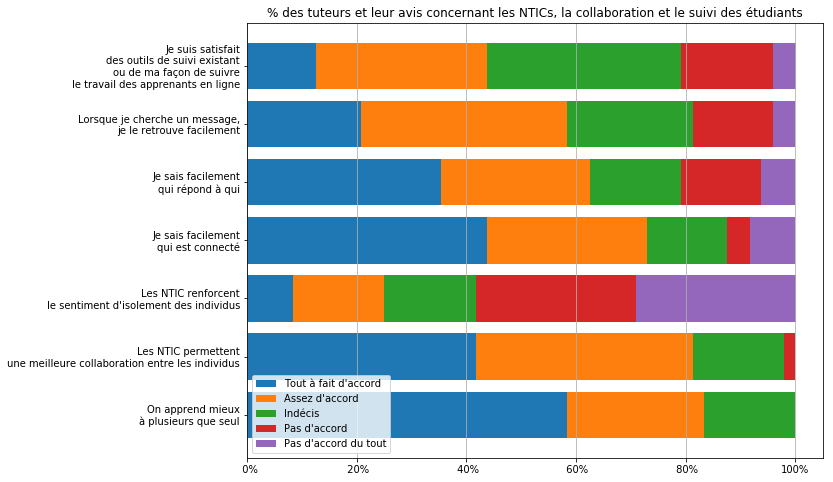

In [64]:
# Le Graphe de la Satisfaction
hist_df = round(get_hist_df(df.loc[:,okCols]) / len(df) * 100, 2)

labels= ["Pas d'accord du tout", "Pas d'accord", "Indécis", "Assez d'accord",  "Tout à fait d'accord"]
title = "% des tuteurs et leur avis concernant les NTICs, la collaboration et le suivi des étudiants"
plot_stacked_horizontal_bar_chart(hist_df, labels, title, reverse=True, size=(20,8), left=.5).savefig('satisfaction.png')

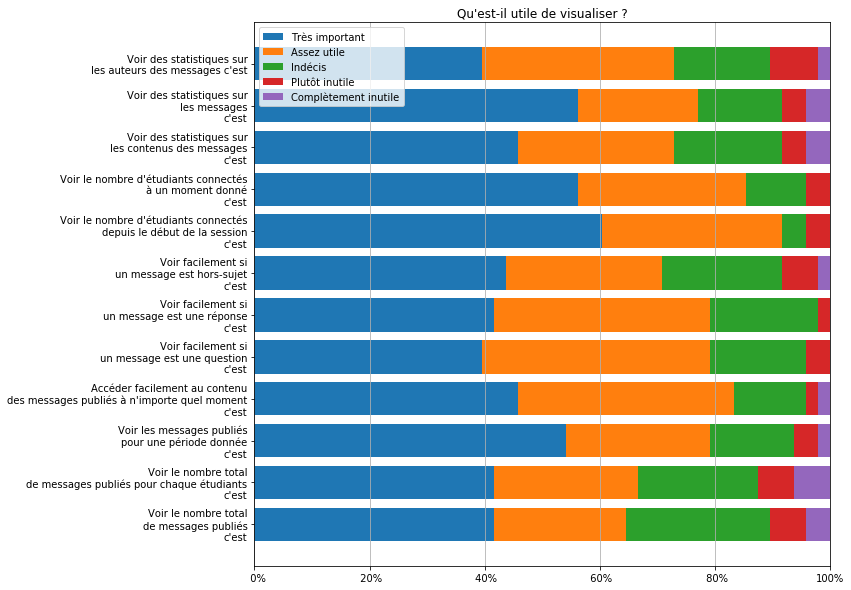

In [65]:
# Le Graphe de l'Utilité
hist_df = round(get_hist_df(df.loc[:,estCols]) / len(df) * 100, 2)

labels= ["Complètement inutile", "Plutôt inutile", "Indécis", "Assez utile", "Très important"]
title = "Qu'est-il utile de visualiser ?"
plot_stacked_horizontal_bar_chart(hist_df, labels, title, reverse=True, size=(20,10), left=.5).savefig('utilite.png')

#### Il reste à représenter les colonnes vraie faux et à réponses ouverte